In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container {width:90% !important;}</style>"))

In [209]:
%matplotlib notebook

from numpy import *
from os import path
home = path.expanduser("~")

import matplotlib.pyplot as plt

# define plot style
width = 0.05
plotMarkerSize = 8
labelfontsize = 15
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6., 4.5]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.format'] = "pdf"

EPS = 1e-16  # a small number

working_path = path.join(home, "JETSCAPE", "build22")

In [2]:
class SimpleHistogram:
    """A simple histogram class"""
    def __init__(self, x_min, x_max, nx):
        self.x_min_ = x_min
        self.x_max_ = x_max
        self.nx_ = nx
        self.dx_ = (x_max - x_min)/nx
        self.bin_x_ = zeros(nx)
        for i in range(nx):
            self.bin_x_[i] = x_min + (i+0.5)*self.dx_
        self.bin_y_ = zeros(nx)
    
    def fill(self, x_in, val):
        idx = int((x_in - self.x_min_)/self.dx_)
        if idx >= 0 and idx < self.nx_:
            self.bin_y_[idx] += val

In [278]:
data_filename = "my_final_state_hadron.txt"
nev = 0
event_list = []
with open(path.join(working_path, data_filename)) as fp:
    line = fp.readline()  # read in the header
    while line:
        nparticles = int(line.split()[3])
        event_i = []
        for ipart in range(nparticles):
            line = fp.readline()
            event_i.append(array([float(i) for i in line.split()]))
        event_list.append(array(event_i))
        nev += 1
        # print("Event {} has {} particles".format(nev, nparticles))
        line = fp.readline()  # read in the header
print("Read in total {} events.".format(nev))

Read in total 1 events.


In [280]:
y_cut = 0.5

def calc_obs(pid):
    
    pTSpectra   = SimpleHistogram(0.0, 3.0, 31)
    v2diff_real = SimpleHistogram(0.0, 3.0, 31)
    v2diff_imag = SimpleHistogram(0.0, 3.0, 31)
    
    multi = 0

    for event_i in event_list:
        npart, ncol = event_i.shape
        for ipart in range(npart):
            if event_i[ipart][1] != pid: continue
            if event_i[ipart][3] > abs(event_i[ipart][6]):
                # compute the particle rapidity
                y = 0.5*log((event_i[ipart][3] + event_i[ipart][6])
                            /(event_i[ipart][3] - event_i[ipart][6] + EPS))
                # compute particle pT
                pT = sqrt(event_i[ipart][4]**2 + event_i[ipart][5]**2.)
                # compute particle phi
                phi = arctan2(event_i[ipart][5], event_i[ipart][4])
                if y < y_cut and y > -y_cut:  # select the rapidity acceptance
                    pTSpectra.fill(pT, 1.)
                    v2diff_real.fill(pT, cos(2.*phi))
                    v2diff_imag.fill(pT, sin(2.*phi))
                    multi +=1

    ### pT-differential
    
    # dN/2pi*pTdpTdy
    delta_y = 2.*y_cut
    delta_pT = pTSpectra.bin_x_[1] - pTSpectra.bin_x_[0]
    pTSpectra.bin_y_ /= (nev*delta_y*delta_pT*2*math.pi)   # divide spectra by dy and dpT
    
    # dN/dy
    dNdy = multi/(nev*delta_y)
    
    # v2(pT)
    v2diff_real.bin_y_ = v2diff_real.bin_y_/(pTSpectra.bin_y_ + EPS)
    v2diff_imag.bin_y_ = v2diff_imag.bin_y_/(pTSpectra.bin_y_ + EPS)
    
    v2diff = sqrt(v2diff_real.bin_y_**2. + v2diff_imag.bin_y_**2.)
    
    ### pT-integrated
    
    # mean pT
    mean_pT = sum(pTSpectra.bin_x_*pTSpectra.bin_y_)/sum(pTSpectra.bin_y_)
    
    # integrated v2
    v2_real_inte = sum(pTSpectra.bin_y_*v2diff_real.bin_y_)/sum(pTSpectra.bin_y_)
    v2_imag_inte = sum(pTSpectra.bin_y_*v2diff_imag.bin_y_)/sum(pTSpectra.bin_y_)
    v2inte = sqrt(v2_real_inte**2. + v2_imag_inte**2.)

    return pTSpectra, dNdy, v2diff, v2inte, mean_pT

In [281]:
pid_list = [211, 321, 2212]

identified_obs = {}

for pid in pid_list:
    
    identified_obs['{:d}'.format(pid)] = calc_obs(pid)
    
pi_obs = identified_obs['211']
k_obs = identified_obs['321']
p_obs = identified_obs['2212']

In [243]:
print(pi_obs[1], k_obs[1], p_obs[1])# dN/dy old

161.1 35.5 9.3


In [244]:
print(pi_obs[3], k_obs[3], p_obs[3])# v2

0.11569724475802176 0.41212517955822486 0.1936276672671543


In [245]:
print(pi_obs[4], k_obs[4], p_obs[4])# mean pT

0.38964978674836304 0.5123580190822353 0.6363163371488032


## 200 GeV

In [282]:
syst_name = "0-5% Au-Au@200 GeV"
file_name = "Au-Au200-05"
export_path = "plots"

In [283]:
#https://www.hepdata.net/record/ins624474
data_200_dNdpT_pi = loadtxt(path.join(working_path, "hydro_session/data", "HEPData-ins624474-v1-Figure_6_Pi+.csv"))
dNdpT_pi_pT = data_200_dNdpT_pi[0:28,0]
dNdpT_pi_pT_error = data_200_dNdpT_pi[0:28,2]-data_200_dNdpT_pi[0:28,1]
dNdpT_pi = data_200_dNdpT_pi[0:28,3]
dNdpT_pi_error = data_200_dNdpT_pi[0:28,4]

In [284]:
data_200_dNdpT_k = loadtxt(path.join(working_path, "hydro_session/data", "HEPData-ins624474-v1-Figure_7_K+.csv"))
dNdpT_k_pT = data_200_dNdpT_k[0:16,0]
dNdpT_k_pT_error = data_200_dNdpT_k[0:16,2]-data_200_dNdpT_k[0:16,1]
dNdpT_k = data_200_dNdpT_k[0:16,3]
dNdpT_k_error = data_200_dNdpT_k[0:16,4]

In [285]:
data_200_dNdpT_p = loadtxt(path.join(working_path, "hydro_session/data", "HEPData-ins624474-v1-Figure_8_Protons.csv"))
dNdpT_p_pT = data_200_dNdpT_p[0:22,0]
dNdpT_p_pT_error = data_200_dNdpT_p[0:22,2]-data_200_dNdpT_p[0:22,1]
dNdpT_p = data_200_dNdpT_p[0:22,3]
dNdpT_p_error = data_200_dNdpT_p[0:22,4]

<IPython.core.display.Javascript object>


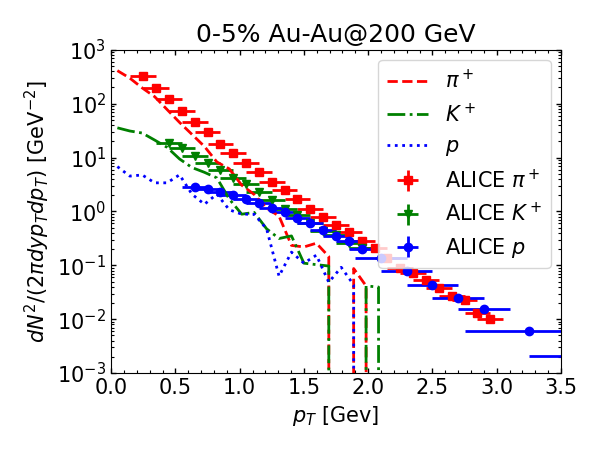

In [289]:
fig = plt.figure()

plt.plot(pi_obs[0].bin_x_, 1/20*pi_obs[0].bin_y_/pi_obs[0].bin_x_, '--r', label = r"$\pi^+$")
plt.plot(k_obs[0].bin_x_, 1/20*k_obs[0].bin_y_/k_obs[0].bin_x_, '-.g', label = r"$K^+$")
plt.plot(p_obs[0].bin_x_, 1/20*p_obs[0].bin_y_/p_obs[0].bin_x_, ':b', label = r"$p$")

plt.errorbar(dNdpT_pi_pT, dNdpT_pi, xerr = dNdpT_pi_pT_error, yerr = dNdpT_pi_error, color='r', fmt='s', label=r'ALICE $\pi^+$')
plt.errorbar(dNdpT_k_pT, dNdpT_k, xerr = dNdpT_k_pT_error, yerr = dNdpT_k_error, color='g', fmt='v', label=r'ALICE $K^+$')
plt.errorbar(dNdpT_p_pT, dNdpT_p, xerr = dNdpT_p_pT_error, yerr = dNdpT_p_error, color='b', fmt='o', label=r'ALICE $p$')

plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$dN^2/(2\pi{}dy p_T dp_T)$ [GeV$^{-2}$]")
plt.xlim([0, 3.5])
plt.ylim([1.e-3, 1.e3])
plt.yscale("log")
plt.title(r"{}".format(syst_name))
plt.tight_layout()

plt.savefig(path.join(working_path, "hydro_session", "{0}/{1}_plot_pT_spectra").format(export_path, file_name), bbox_inches='tight')

In [187]:
#mulitplicity 20–30% Centrality dNch/dη π+ π− K+ K− p pbar Norm. Uncertainty; https://arxiv.org/pdf/1303.0737.pdf
data_2760_dNdy = [649, 23, 307, 20, 306, 20, 46, 4, 46, 4, 14.4, 1.2, 14.5, 1.2]

<IPython.core.display.Javascript object>


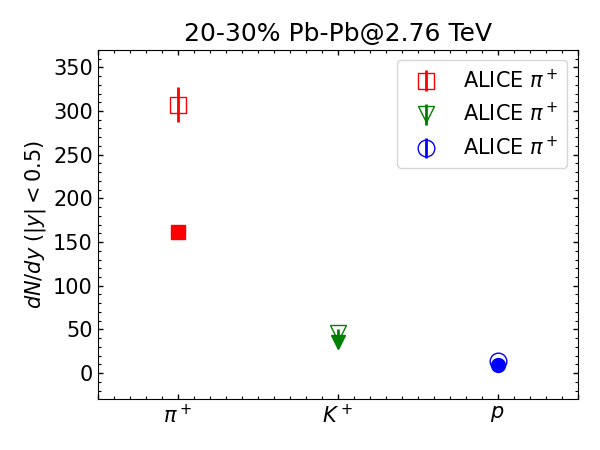

In [262]:
fig = plt.figure()

plt.errorbar(0, data_2760_dNdy[2], yerr = data_2760_dNdy[3], color='r', fmt='s', markersize=12, markerfacecolor='none', label=r'ALICE $\pi^+$')
plt.errorbar(1, data_2760_dNdy[6], yerr = data_2760_dNdy[7], color='g', fmt='v', markersize=12, markerfacecolor='none', label=r'ALICE $\pi^+$')
plt.errorbar(2, data_2760_dNdy[10], yerr = data_2760_dNdy[11], color='b', fmt='o', markersize=12, markerfacecolor='none', label=r'ALICE $\pi^+$')

plt.plot(0, pi_obs[1], 's', color='r', markersize=10)
plt.plot(1, k_obs[1], 'v', color='g', markersize=10)
plt.plot(2, p_obs[1], 'o', color='b', markersize=10)

plt.legend(loc=0, ncol=1)
axes=plt.gca()
axes.set_xticks([-0.5,0,1,2,2.5])
axes.set_xticklabels(["", r"$\pi^+$", r"$K^+$", r"$p$", ""])
plt.ylabel(r"$dN/dy\; (|y|<0.5)$")
plt.ylim([-30, 370])
plt.title(r"{}".format(syst_name))
plt.tight_layout()

plt.savefig(path.join(working_path, "hydro_session", "{0}/{1}_plot_multiplicity").format(export_path, file_name), bbox_inches='tight')

In [193]:
#mean pT 20–30% Centrality π+ π− K+ K− p pbar
data_2760_meanPT = [0.512, 0.017, 0.516, 0.017, 0.860, 0.029, 0.851, 0.034, 1.281, 0.033, 1.295, 0.039]

<IPython.core.display.Javascript object>


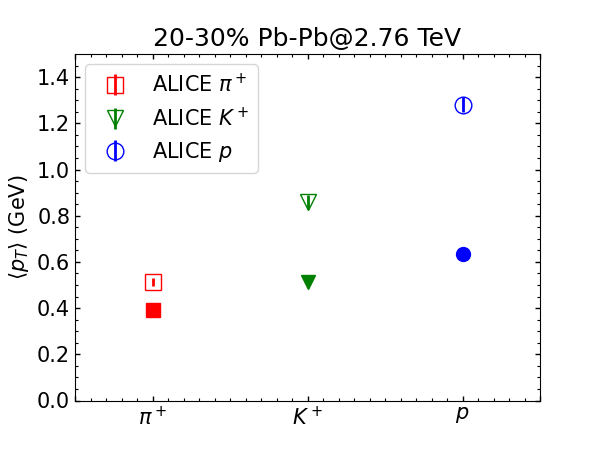

In [261]:
fig = plt.figure()

plt.errorbar(0, data_2760_meanPT[0], yerr = data_2760_meanPT[1], color='r', fmt='s', markersize=12, markerfacecolor='none', label=r'ALICE $\pi^+$')
plt.errorbar(1, data_2760_meanPT[4], yerr = data_2760_meanPT[5], color='g', fmt='v', markersize=12, markerfacecolor='none', label=r'ALICE $K^+$')
plt.errorbar(2, data_2760_meanPT[8], yerr = data_2760_meanPT[9], color='b', fmt='o', markersize=12, markerfacecolor='none', label=r'ALICE $p$')

plt.plot(0, pi_obs[4], 's', color='r', markersize=10)
plt.plot(1, k_obs[4], 'v', color='g', markersize=10)
plt.plot(2, p_obs[4], 'o', color='b', markersize=10)

plt.legend(loc=0, ncol=1)
axes=plt.gca()
axes.set_xticks([-0.5,0,1,2,2.5])
axes.set_xticklabels(["", r"$\pi^+$", r"$K^+$", r"$p$", ""])
plt.ylabel(r"$\langle p_T \rangle$ (GeV)")
plt.ylim([0.0, 1.5])
plt.title(r"{}".format(syst_name))

plt.savefig(path.join(working_path, "hydro_session", "{0}/{1}_plot_mean_pT").format(export_path, file_name), bbox_inches='tight')

<IPython.core.display.Javascript object>


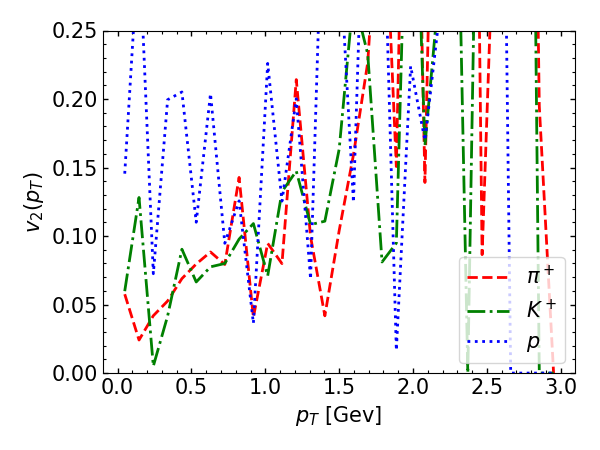

In [24]:
fig = plt.figure()

plt.plot(pi_obs[0].bin_x_, pi_obs[1], '--r', label = r"$\pi^+$")
plt.plot(k_obs[0].bin_x_, k_obs[1], '-.g', label = r"$K^+$")
plt.plot(p_obs[0].bin_x_, p_obs[1], ':b', label = r"$p$")

plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$v_2(p_T)$")
plt.ylim([0., 0.25])
plt.tight_layout()

# save plot to the Desktop
#plt.savefig('v2_pTdiff')

In [41]:
pTSpectra.bin_y_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [72]:
particle_list = ['pi', 'kaon', 'proton']


In [65]:
pi_obs = identified_obs(211, 0.001, 3.0)
k_obs = identified_obs(321, 0.001, 3.0)
p_obs = identified_obs(2212, 0.001, 3.0)

In [15]:
test_pi = identified_obs(211)
#test_k =  identified_obs(321)

<IPython.core.display.Javascript object>


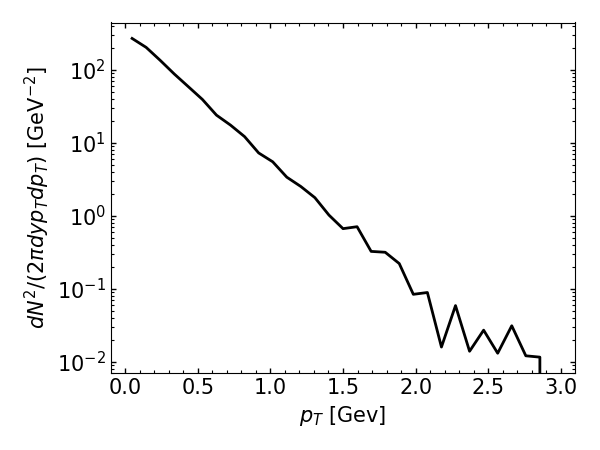

In [16]:
fig = plt.figure()

plt.plot(test_pi[0].bin_x_, test_pi[0].bin_y_/test_pi[0].bin_x_, '-k')
#plt.plot(test_k[0].bin_x_, test_k[0].bin_y_/test_k[0].bin_x_, '--r')


#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$dN^2/(2\pi{}dy p_T dp_T)$ [GeV$^{-2}$]")
plt.yscale("log")
plt.tight_layout()

# save plot to the Desktop
#plt.savefig('pTSpectra')

<IPython.core.display.Javascript object>


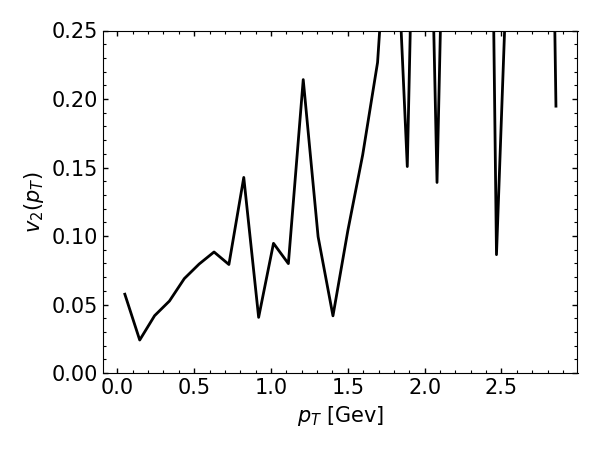

In [24]:
fig = plt.figure()

plt.plot(test_pi[0].bin_x_, test_pi[1], '-k')

#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$v_2(p_T)$")
plt.ylim([0., 0.25])
plt.tight_layout()

# save plot to the Desktop
plt.savefig('v2_pTdiff')

In [17]:
test_pi = identified_obs(211)
test_k =  identified_obs(321)

<IPython.core.display.Javascript object>


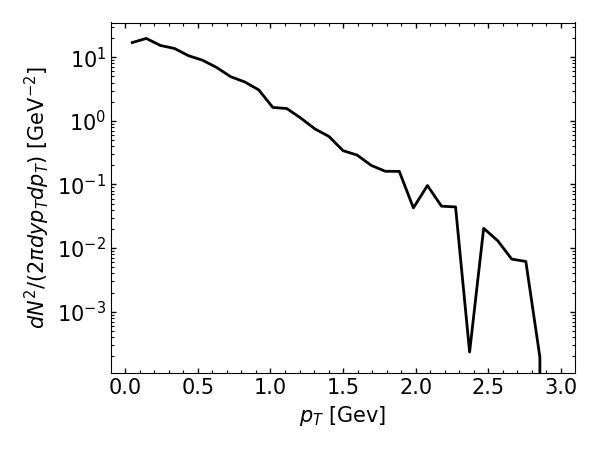

In [18]:
fig = plt.figure()

plt.plot(test_pi[0].bin_x_, test_pi[0].bin_y_/test_pi[0].bin_x_, '-k')
#plt.plot(test_k[0].bin_x_, test_k[0].bin_y_/test_k[0].bin_x_, '--r')


#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$dN^2/(2\pi{}dy p_T dp_T)$ [GeV$^{-2}$]")
plt.yscale("log")
plt.tight_layout()

# save plot to the Desktop
#plt.savefig('pTSpectra')

<IPython.core.display.Javascript object>


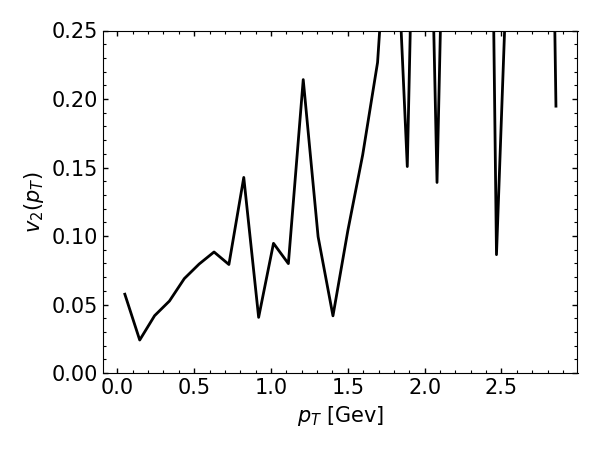

In [24]:
fig = plt.figure()

plt.plot(test_pi[0].bin_x_, test_pi[1], '-k')

#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$v_2(p_T)$")
plt.ylim([0., 0.25])
plt.tight_layout()

# save plot to the Desktop
plt.savefig('v2_pTdiff')

<IPython.core.display.Javascript object>


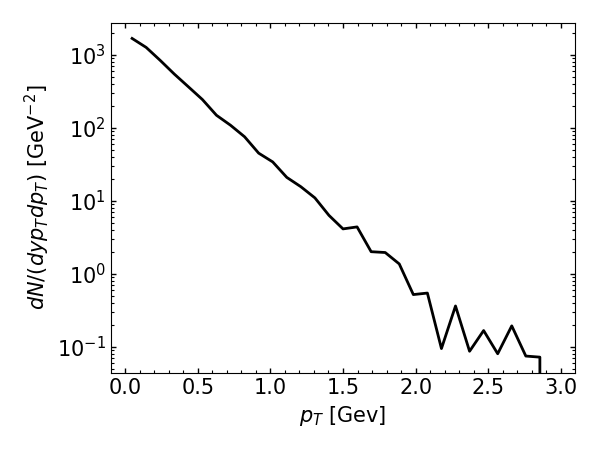

In [5]:
fig = plt.figure()

plt.plot(pTSpectra.bin_x_, pTSpectra.bin_y_/pTSpectra.bin_x_, '-k')

#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$dN/(dy p_T dp_T)$ [GeV$^{-2}$]")
plt.yscale("log")
plt.tight_layout()

# save plot to the Desktop
plt.savefig('pTSpectra')

<IPython.core.display.Javascript object>


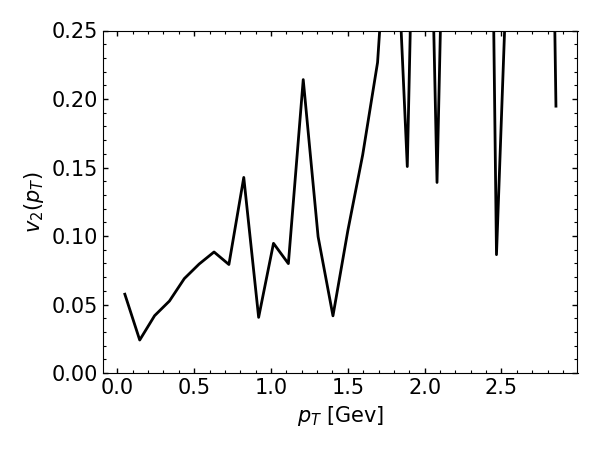

In [6]:
fig = plt.figure()

plt.plot(v2diff_real.bin_x_, v2diff, '-k')

#plt.legend(loc=0)
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$v_2(p_T)$")
plt.ylim([0., 0.25])
plt.tight_layout()

# save plot to the Desktop
plt.savefig('v2_pTdiff')